# Kdg adversarial robustness benchmark comparison against reference algorithms
This benchmarking is continuation of previous kdf benchmarking experiment from `kdf_gaussian_xor_label_noise.ipynb`, thus large part of the code base is adapted from the original notebook. In this notebook, kdg is benchmarked against SVM, RF, MLP, SPORF, and MORF algorithms.

As indicated previously, the estimated beyes error is 0.267 referenced from `bayeserrorestimate_gaussianparity.ipynb`

The notebook is created by `Jong M. Shin` who can be reached at `jshin.m@gmail.com`

In [1]:
from datetime import datetime

today = datetime.now()
str(today)

'2021-12-19 12:58:29.626797'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns
import pickle
from IPython.display import clear_output

from kdg.utils import generate_gaussian_parity
from functions.kdg_adversarial import plot_gaussians
from functions.kdg_adversarial import label_noise_trial_clf

from kdg import kdf
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
try: #conditional import as rerf is currently only available in linux and mac
    from rerf.rerfClassifier import rerfClassifier 
except ImportError:
    rerfClassifier = RandomForestClassifier

## Benchmark global settings
The indices of classifiers in the list is as follows
1. Kdg
2. SVM
3. RF
4. MLP
5. SPORF

In [3]:
n_samples = 5000 #total number of samples
n_estimators = 500 #number of estimators for tree-based algorithms
proportions = [0.0, 0.1, 0.2, 0.3, 0.4] #number of adverarial cases
reps = np.arange(10) #number of repetition
label = ['KDG', 'SVM', 'RF', 'MLP', 'SPORF']

## Initialization of classifiers

- kdg: Base class is used with global parameters applied to all reference algorithms equally
- SVM, RF, MLP: The parameterization is in reference to the reference algorithms trained on S-XOR simulation dataset from [inductive bias experiment](https://github.com/jshinm/inductive-bias-experiment)
- SPORF and MORF: The same base parameters used both on Adam Li's experiment and the inductive bias experiment

In [4]:
def init_models():
    global n_estimators
    
    clf_kdf = kdf(kwargs = {'n_estimators': n_estimators})
    clf_rf = RandomForestClassifier(max_depth=10, n_estimators=n_estimators, n_jobs=-1)
    clf_svm = svm.NuSVC(gamma='auto', probability=True)
    clf_mlp = MLPClassifier(alpha=0, hidden_layer_sizes=100, learning_rate_init=0.0001, max_iter=7000)
    clf_sporf = rerfClassifier(
    projection_matrix='RerF',
    n_jobs=-1,
    n_estimators=n_estimators,
    max_features='auto',
    max_depth=10
    ) #SPORF specification

# clf_morf = rerfClassifier(
#     projection_matrix='MT-MORF',
#     n_jobs=-1,
#     n_estimators=n_estimators,
#     max_features='auto',
#     max_depth=10,
#     image_height=1,
#     image_width=2,
#     patch_height_max=1,
#     patch_height_min=1,
#     patch_width_max=1,
#     patch_width_min=1
# ) #MORF specification

    clf = [clf_kdf, clf_svm, clf_rf, clf_mlp, clf_sporf]

    return clf

## Adversarial training distribution
As noted previously, the same parameterization is used for noise implementation

Text(0.5, 1.0, '20% Flipped Labels')

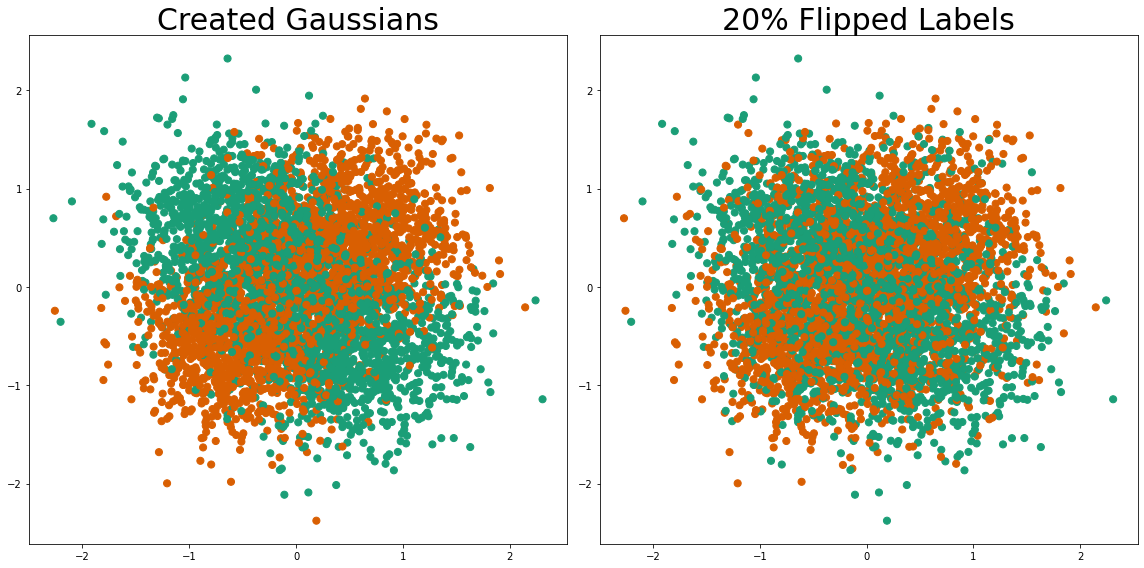

In [5]:
# Show the sample blobs / Gaussians
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# Generate original distribution
X, y = generate_gaussian_parity(n_samples, cluster_std=0.5)
plot_gaussians(X, y, ax=ax[0])
plt.gca().set_title('Uncontaminated Labels', fontsize=30)

# Randomly flip labels
p = 0.20
n_noise = np.int32(np.round(len(X) * p))
noise_indices = random.sample(range(len(X)), n_noise)
y[noise_indices] = 1 - y[noise_indices]
plot_gaussians(X, y, ax=ax[1])
plt.gca().set_title('20% Flipped Labels', fontsize=30)

## Adversarial benchmarking script

In [6]:
def run_exp(n_samples=n_samples):
    global label, proportions, reps
    
    col = ['Proportions', 'Iterations'] + label
    df = pd.DataFrame(columns=col)

    for p in proportions:
        for ii in reps:
            clear_output()
            print(f'Currently at P={p}, Rep={ii}')

            clf = init_models()
            err_i = label_noise_trial_clf(n_samples=n_samples, p=p, clf=clf)
            tmp = [p, ii] + err_i
            df.loc[len(df)] = tmp

    clear_output()
    print(f'training ended in {datetime.now()-today}')

    return df

In [7]:
df = run_exp()

training ended in 0:42:03.049720


#### Examine result in tabulated form

In [8]:
df.groupby(['Proportions']).mean()

,Iterations,KDG,SVM,RF,MLP,SPORF
Proportions,,,,,,
0.0,4.5,0.2604,0.3588,0.2597,0.2572,0.2597
0.1,4.5,0.2800,0.4365,0.2769,0.2656,0.2742
0.2,4.5,0.2829,0.4411,0.2807,0.2655,0.2712
0.3,4.5,0.2935,0.4433,0.2904,0.2717,0.2756
0.4,4.5,0.3603,0.4571,0.3523,0.2921,0.3101


### Save result table

In [15]:
with open(f'{today.date()}_kdg_adversarial_600samples.pickle', 'wb') as handle:
    pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Visualization of the experiment

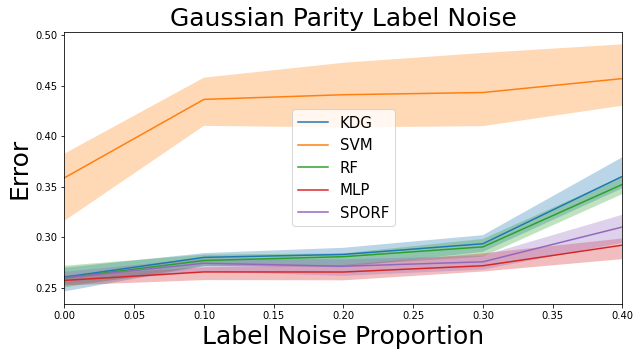

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
dfg = df.groupby(['Proportions'])
for l in label:
    if l == 'SVM':
        pass
    ax.plot(proportions, dfg.mean()[l], label=l)
    ax.fill_between(proportions, dfg.quantile(0.25)[l], dfg.quantile(0.75)[l], alpha=0.3)

ax.set_xlabel("Label Noise Proportion", fontsize=25)
ax.set_ylabel("Error", fontsize=25)
ax.set_title("Gaussian Parity Label Noise", fontsize=25)
ax.set_xlim(0, proportions[-1])
ax.legend(fontsize=15)

In [14]:
# fig.savefig(f'{today.date()}_kdg_adversarial_benchmarking_with_SVM_600sample.jpg', bbox_inches='tight')